# Solar radiation forecasting
The **prediction of solar systems power production** is necessary for the proper operation of the power grid or for the optimal management of the energy flows produced in the solar system. Before forecasting the power output of solar systems, it is **essential to predict the solar irradiation**.



# Methodology

![metodologia](https://drive.google.com/uc?export=view&id=1WTCNJ3kc3wT_erNxbgNbR_gCJbfP5DbS)

# Neural Networks for Time Series Prediction

Time series prediction algorithms find **behavioral patterns** over time.

**Artificial Neural Networks (ANNs)** are the most widely used solar irradiance prediction methods. The widespread use of **ANNs** can be explained by the improved computational capacity, high storage availability and improved accuracy achieved by different **ANN architectures**. About **79%** of the methods used in weather forecasting are based on neural networks and **specialized neural network architectures** have been developed for time series.

# Recurrent neural network
![LSTM_cell](https://drive.google.com/uc?export=view&id=1Ysx4DH5NQGiHxBc-M15l4EDhocq9APD0)

# Long short-term memory (LSTM) neural networks

![LSTM_cell](https://drive.google.com/uc?export=view&id=1nvdmET_5ZMceZ2KTpdKEEgWs6Z78jrK6)

Diagram of a LSTM network unit (*LSTM unit*). The unit is composed of four neurons, each of which receives as input the current state $x_t$ and the previous state $h_{t-1}$. The input gate can enable or disable the state of the input neuron that generates the state $c_t$, which has a linear *self-loop* represented by the black square. The forgetting gate controls the weight of the autobloop. The output gate can activate or deactivate the state of the $h_t$ unit.

# Encoder-Decoder architecture

![encoder_decoder](https://drive.google.com/uc?export=view&id=1zfM6mz_plpHST2wHHD5nUB8IGQnkgxWr)

The encoder creates an internal representation C. The decoder transforms C into the corresponding output vector.

# Sections

[1. Import libreries](#import_librerias)

[2. Load databases](#cargar_datos)

[3. Forecasting models](#modelos)

[4. Challenges](#retos)

<a name="import_librerias"></a>
# 1. Import libreries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [ ]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from time import time

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

<a name="cargar_datos"></a>
# 2. Load databases

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


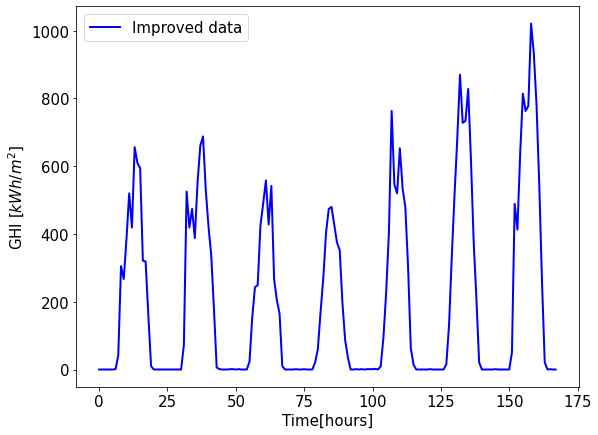

In [ ]:
GHI = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML in PV systems/Forecasting/GHI_sa.csv')

plt.figure()
plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(GHI[0:24*7],'b', label='Improved data', linewidth=2)
plt.legend(loc='best', fontsize=15)
plt.xlabel("Time[hours]", fontsize=15)
plt.xticks(size=15)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=15)
plt.yticks(size=15)
# plt.savefig('/figure.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
GHI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175200 entries, 0 to 175199
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       175200 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB


<a name="modelos"></a>
# 3. Forecasting with LSTM neural networks

In [ ]:
# divide the input vector into samples

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

### 3.1 Normalizing and dividing into: training, test and validation

In [ ]:
from sklearn.preprocessing import StandardScaler

# 1 first year for training
# 1 year for testing
# 1 year for validation

X = np.array(GHI)
scaler = StandardScaler().fit(X.reshape(-1, 1))
X = scaler.transform(X.reshape(-1, 1))
X = X.ravel()

n = 365*24
X_train = X[:n]
X_val = X[n:2*n]
X_test = X[2*n:3*n]

In [ ]:
print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(175200,)
(8760,)
(8760,)
(8760,)


## 3.2 Daily forecasting model

In [ ]:
# Choose number of input and output steps
n_steps_in_d = 168      # 7 previous days
n_steps_out_d = 168      # predict next day

# divide into samples
X_t, y_t = split_sequence(X_train, n_steps_in_d, n_steps_out_d)
X_v, y_v = split_sequence(X_val, n_steps_in_d, n_steps_out_d)

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(8425, 168)
(8425, 168)
(8425, 168)
(8425, 168)


In [ ]:
# Resize [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X_t = X_t.reshape((X_t.shape[0], X_t.shape[1], n_features))
y_t = y_t.reshape((y_t.shape[0], y_t.shape[1], n_features))
X_v = X_v.reshape((X_v.shape[0], X_v.shape[1], n_features))
y_v = y_v.reshape((y_v.shape[0], y_v.shape[1], n_features))

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(8425, 168, 1)
(8425, 168, 1)
(8425, 168, 1)
(8425, 168, 1)


### 3.2.1 Training model: 12 neurons on encoder and decoder

In [ ]:
# define the model

# encoder
model_d = Sequential()
model_d.add(LSTM(5, input_shape=(n_steps_in_d, n_features)))
model_d.add(RepeatVector(n_steps_out_d))

# decoder
model_d.add(LSTM(5, return_sequences=True))
model_d.add(TimeDistributed(Dense(1)))
model_d.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_d.fit(X_t, y_t, epochs=100, batch_size=128, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("El modelo tardó %.2f segundos en entrenar."% (time() - start)) 

Epoch 1/100
66/66 [==============================] - 5s 34ms/step - loss: 1.0788 - val_loss: 1.0332
Epoch 2/100
66/66 [==============================] - 1s 21ms/step - loss: 1.0488 - val_loss: 1.0319
Epoch 3/100
66/66 [==============================] - 1s 20ms/step - loss: 1.0349 - val_loss: 1.0311
Epoch 4/100
66/66 [==============================] - 1s 21ms/step - loss: 1.0321 - val_loss: 1.0304
Epoch 5/100
66/66 [==============================] - 1s 20ms/step - loss: 1.0311 - val_loss: 1.0297
Epoch 6/100
66/66 [==============================] - 1s 20ms/step - loss: 1.0356 - val_loss: 1.0285
Epoch 7/100
66/66 [==============================] - 1s 20ms/step - loss: 1.0314 - val_loss: 1.0253
Epoch 8/100
66/66 [==============================] - 1s 20ms/step - loss: 1.0256 - val_loss: 1.0250
Epoch 9/100
66/66 [==============================] - 1s 20ms/step - loss: 1.0285 - val_loss: 1.0238
Epoch 10/100
66/66 [==============================] - 1s 20ms/step - loss: 1.0287 - val_loss: 1.0226

In [ ]:
model_d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12)                672       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 24, 12)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 12)            1200      
_________________________________________________________________
time_distributed (TimeDistri (None, 24, 1)             13        
Total params: 1,885
Trainable params: 1,885
Non-trainable params: 0
_________________________________________________________________


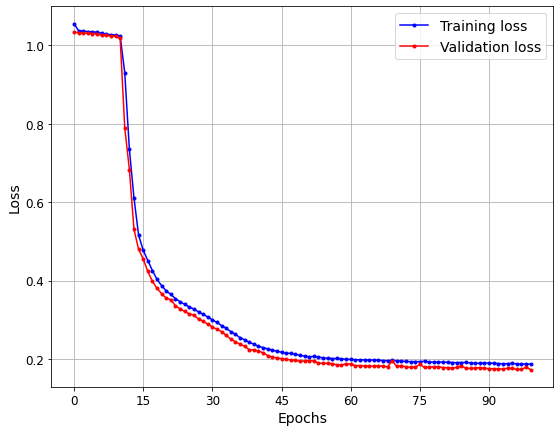

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, len(history.epoch), 0.1, 0.15])
    # plt.axis([1, len(history.epoch), min(history.history["val_loss"]), max(history.history["val_loss"])])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

plot_learning_curves(history.history["loss"], history.history["val_loss"])

## 3.3 Daily forecasting in test set

In [ ]:
# Daily forecasting in test set
X_test_, y_test_ = split_sequence(X_test, n_steps_in_d, n_steps_out_d)
y_test = scaler.inverse_transform(y_test_)

print(X_test_.shape)
print(y_test.shape)

(8713, 24)
(8713, 24)


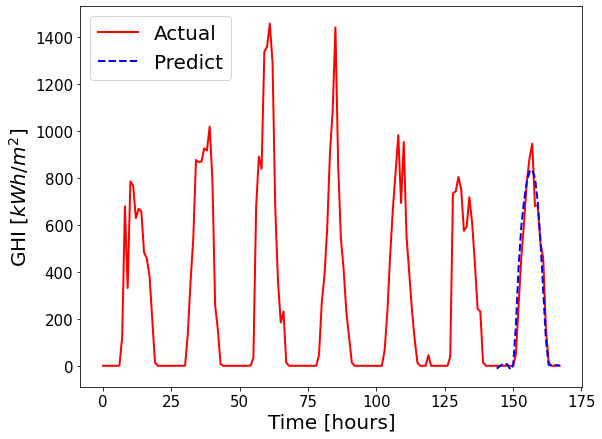

Root mean square error:  70.38445506605849
Mean absolute error:  44.94982849558195
R-Squared:  0.954522971989712


In [ ]:
predict = 24*8
x_input = X_test_[predict].reshape((1, n_steps_in_d, n_features))
yhat_norm_d = model_d.predict(x_input, verbose=0)
yhat_d = scaler.inverse_transform(yhat_norm_d)
yhat_d = yhat_d[0]

var = scaler.inverse_transform(X_test)
actual = y_test[predict]
prev = var[predict-24*6:predict]
prev = np.hstack((prev,actual))

time = np.arange(24*7)
plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(prev,'r',  label='Actual', linewidth=2)
plt.plot(time[24*6:], yhat_d.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
# plt.savefig('Figuras_Informe/predic_1_day_01012012.png', format='png', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_d))
mae = mean_absolute_error(actual, yhat_d)
r2 = r2_score(actual, yhat_d)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

<a name="retos"></a>
# 4. Challenges
1. Train different architectures (number of neurons, input days).
2. Build a model to predict the irradiance of a week.
3. Test with more data (remember we used 1 year for training, 1 year for testing, and 1 year for validation).

![encoder_decoder](https://drive.google.com/uc?export=view&id=1g64xhbpqZRVs4__z68SczgsDsj0hthgN)
